# Lecture 5 Task

## 1. Import Libraries

In [ ]:
import pandas as pd
import numpy as np
import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder 
import matplotlib.pyplot as plt
import requests
import io


## 2. Load and Prepare Dataset

In [ ]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data"

col_names = ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach',
             'exang', 'oldpeak', 'slope', 'ca', 'thal', 'target']

try:
    s = requests.get(url).content
except Exception as e:
    print(f"Error loading dataset: {e}")
    print("Please ensure the URL is correct or download the data manually.")
    df = pd.DataFrame(np.random.rand(100, 14), columns=col_names)
    df['target'] = np.random.randint(0, 2, 100)

df = pd.read_csv("processed.cleveland.data.csv", names=col_names, na_values='?')
print("Dataset loaded successfully. Shape:", df.shape)
print("First 5 rows:")
print(df.head())

# --- Data Preprocessing ---

# Handle Missing Values (simple strategy: drop rows with missing values)
print(f"\nMissing values before handling:\n{df.isnull().sum()}")
df.dropna(inplace=True)
print(f"\nShape after dropping rows with missing values: {df.shape}")

# Define Features (X) and Target (y)
# The target variable indicates presence (values 1, 2, 3, 4) or absence (value 0) of heart disease.
# We'll convert it to a binary classification problem (0: absence, 1: presence).
X = df.drop('target', axis=1)
y = df['target'].apply(lambda x: 1 if x > 0 else 0) # Binarize target variable

# Ensure all features are numeric (some might be object type if not parsed correctly)
# In this specific dataset, columns 'ca' and 'thal' might be loaded as objects if they contained '?'
# After dropna, they should be convertible to numeric types.
X = X.apply(pd.to_numeric)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

print(f"\nTraining set shape: X_train={X_train.shape}, y_train={y_train.shape}")
print(f"Testing set shape: X_test={X_test.shape}, y_test={y_test.shape}")
print(f"\nTarget variable distribution in training set:\n{y_train.value_counts(normalize=True)}")
print(f"\nTarget variable distribution in test set:\n{y_test.value_counts(normalize=True)}")

Dataset loaded successfully. Shape: (303, 14)
First 5 rows:
    age  sex   cp  trestbps   chol  fbs  restecg  thalach  exang  oldpeak  \
0  63.0  1.0  1.0     145.0  233.0  1.0      2.0    150.0    0.0      2.3   
1  67.0  1.0  4.0     160.0  286.0  0.0      2.0    108.0    1.0      1.5   
2  67.0  1.0  4.0     120.0  229.0  0.0      2.0    129.0    1.0      2.6   
3  37.0  1.0  3.0     130.0  250.0  0.0      0.0    187.0    0.0      3.5   
4  41.0  0.0  2.0     130.0  204.0  0.0      2.0    172.0    0.0      1.4   

   slope   ca  thal  target  
0    3.0  0.0   6.0       0  
1    2.0  3.0   3.0       2  
2    2.0  2.0   7.0       1  
3    3.0  0.0   3.0       0  
4    1.0  0.0   3.0       0  

Missing values before handling:
age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          4
thal        2
target      0
dtype: int64

Shape after dropping rows with missing values: (297, 1

## 3. Train Initial Decision Tree (Unpruned)

In [11]:
# Initialize the Decision Tree Classifier with entropy criterion
dt_unpruned = DecisionTreeClassifier(criterion='entropy', random_state=42)

# Train the model
dt_unpruned.fit(X_train, y_train)

# Predict on the test set
y_pred_unpruned = dt_unpruned.predict(X_test)

# Calculate accuracy
accuracy_unpruned = accuracy_score(y_test, y_pred_unpruned)
print(f"Accuracy of the unpruned Decision Tree: {accuracy_unpruned:.4f}")

# Store accuracy for later comparison in conclusion (optional)
# You would need to ensure these variables are accessible in the final conclusion cell if using a notebook environment.
# Note: This was the part causing issues in the JSON, as these variables aren't available when defining the static JSON structure.
# In a pure script or notebook execution, this works fine.

Accuracy of the unpruned Decision Tree: 0.7444


## 4. Visualize the Unpruned Tree with Entropy

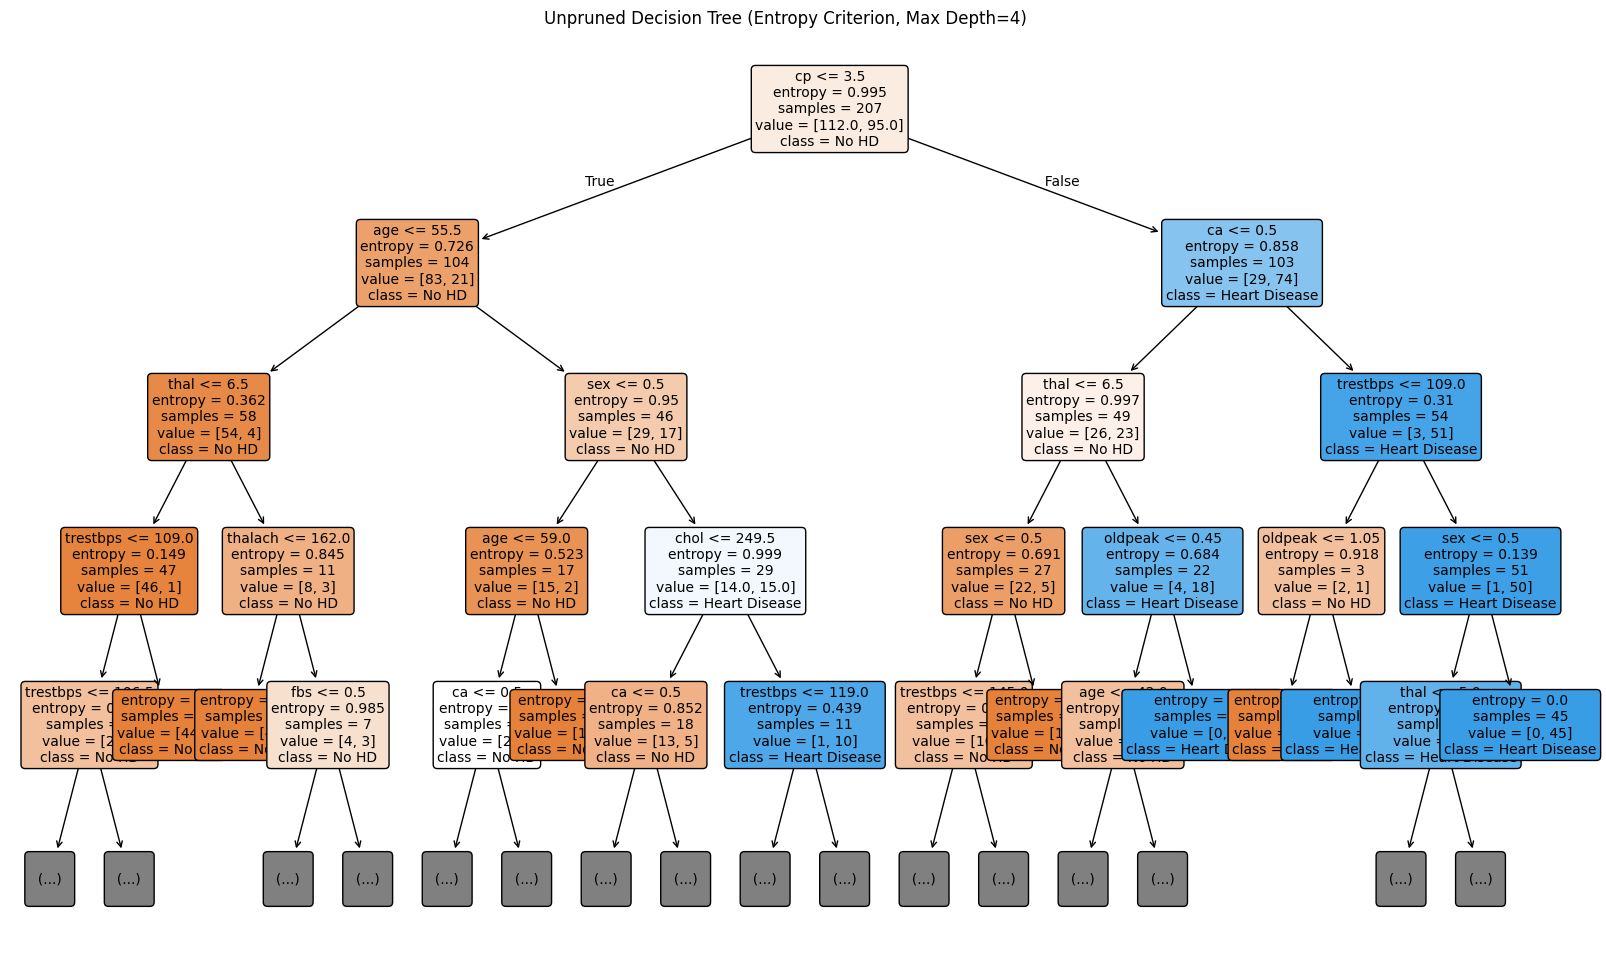

In [12]:
plt.figure(figsize=(20, 12))
plot_tree(dt_unpruned,
          filled=True,
          feature_names=X.columns,
          class_names=['No HD', 'Heart Disease'], # 0: No HD, 1: Heart Disease
          rounded=True,
          fontsize=10,
          max_depth=4) # Limit depth for readability, remove for full tree
plt.title("Unpruned Decision Tree (Entropy Criterion, Max Depth=4)")
plt.show()

## 5. Decision Tree Pruning (Cost Complexity Pruning)

Number of nodes in the tree vs alpha: [65, 59, 53, 51, 47, 47, 45, 41, 37, 33, 31, 29, 27, 25, 23, 21, 19, 17, 11, 9, 7, 5, 3]
Number of effective alphas explored: 23


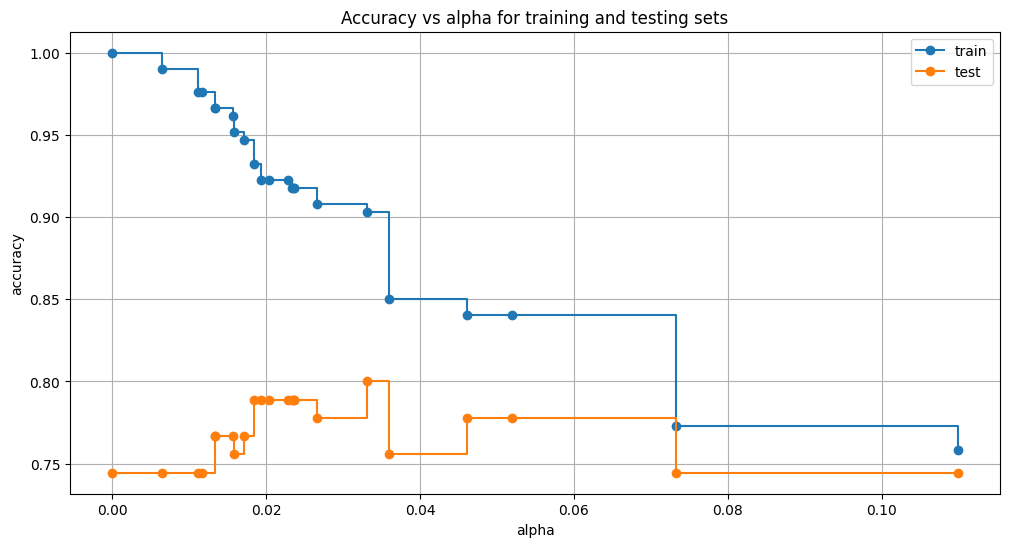


Best ccp_alpha found: 0.033138
Accuracy of the pruned Decision Tree: 0.8000
Number of nodes in pruned tree: 17
Number of nodes in unpruned tree: 65


In [ ]:
path = dt_unpruned.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

ccp_alphas = ccp_alphas[:-1]

clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(criterion='entropy', random_state=42, ccp_alpha=ccp_alpha)
    clf.fit(X_train, y_train)
    clfs.append(clf)

print(f"Number of nodes in the tree vs alpha: {[clf.tree_.node_count for clf in clfs]}")
print(f"Number of effective alphas explored: {len(ccp_alphas)}")

train_scores = [accuracy_score(y_train, clf.predict(X_train)) for clf in clfs]
test_scores = [accuracy_score(y_test, clf.predict(X_test)) for clf in clfs]

fig, ax = plt.subplots(figsize=(12, 6))
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas, train_scores, marker='o', label="train", drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker='o', label="test", drawstyle="steps-post")
ax.legend()
plt.grid()
plt.show()

if len(test_scores) > 0:
    best_alpha_index = np.argmax(test_scores)
    best_ccp_alpha = ccp_alphas[best_alpha_index]
    print(f"\nBest ccp_alpha found: {best_ccp_alpha:.6f}")

    dt_pruned = DecisionTreeClassifier(criterion='entropy', random_state=42, ccp_alpha=best_ccp_alpha)
    dt_pruned.fit(X_train, y_train)

    y_pred_pruned = dt_pruned.predict(X_test)
    accuracy_pruned = accuracy_score(y_test, y_pred_pruned)
    print(f"Accuracy of the pruned Decision Tree: {accuracy_pruned:.4f}")
    print(f"Number of nodes in pruned tree: {dt_pruned.tree_.node_count}")
    print(f"Number of nodes in unpruned tree: {dt_unpruned.tree_.node_count}")
else:
    print("\nNo pruning possible (tree might be too simple or already optimal).")
    dt_pruned = dt_unpruned
    accuracy_pruned = accuracy_unpruned
    best_ccp_alpha = 0 

## 6. Visualize the Pruned Tree

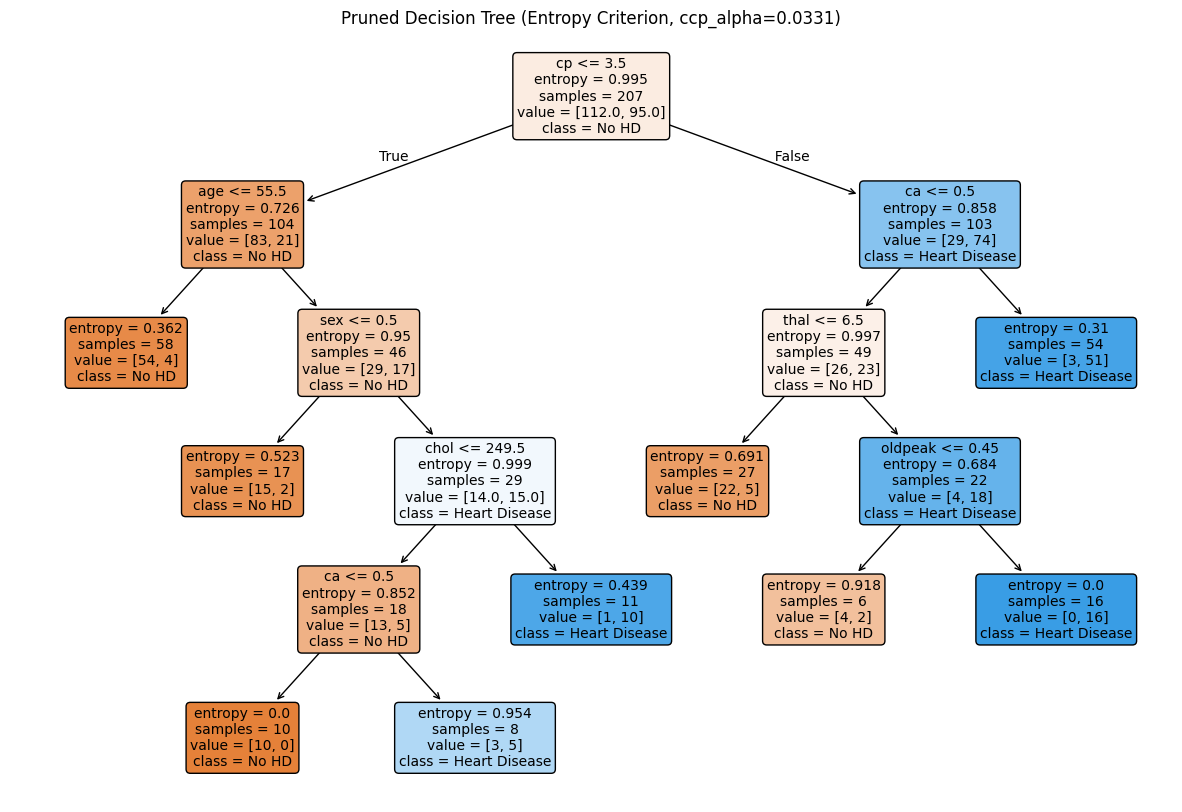

In [ ]:
if 'dt_pruned' in locals() and dt_pruned is not None:
    plt.figure(figsize=(15, 10))
    plot_tree(dt_pruned,
              filled=True,
              feature_names=X.columns,
              class_names=['No HD', 'Heart Disease'],
              rounded=True,
              fontsize=10)
    plt.title(f"Pruned Decision Tree (Entropy Criterion, ccp_alpha={best_ccp_alpha:.4f})")
    plt.show()
else:
    print("Pruned tree visualization skipped as pruning might not have been performed.")

## 7. 3D Visualization of Data (using Plotly)

In [15]:
# Select three features for visualization
feature1 = 'age'
feature2 = 'chol' # Cholesterol
feature3 = 'thalach' # Max heart rate achieved

# Create a temporary DataFrame for plotting with target variable
# Ensure X_test and y_test are available from the split
if 'X_test' in locals() and 'y_test' in locals():
    plot_df = X_test.copy()
    plot_df['target'] = y_test
    # Map target numeric to string for better legend
    plot_df['target_label'] = plot_df['target'].map({0: 'No Heart Disease', 1: 'Heart Disease'})


    # Create the 3D scatter plot
    fig_3d = px.scatter_3d(plot_df,
                           x=feature1,
                           y=feature2,
                           z=feature3,
                           color='target_label',
                           title=f'3D Scatter Plot: {feature1} vs {feature2} vs {feature3}',
                           labels={'target_label': 'Heart Disease Status'},
                           color_discrete_map={'No Heart Disease': 'blue', 'Heart Disease': 'red'},
                           opacity=0.7)

    fig_3d.update_layout(margin=dict(l=0, r=0, b=0, t=40)) # Adjust layout
    fig_3d.show()
else:
    print("Skipping 3D plot as test data is not available.")